In [143]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras import regularizers

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import to_categorical
import pydot

from scipy.stats import norm
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap
shap.initjs()

In [144]:
# Load the data containing the genecounts
genecounts = pd.read_csv("full_genecounts.csv")
# Initialise the scaler
scaler = StandardScaler()
# scale the genecounts 
genecounts_scaled = scaler.fit_transform(genecounts.iloc[:, 1:])
genecounts_scaled = pd.DataFrame(genecounts_scaled, columns = genecounts.columns[1:])

genecounts_scaled.insert(0, 'gene_id', genecounts['gene_id'])
genecounts_scaled = genecounts_scaled.set_index("gene_id")
genecounts_scaled = genecounts_scaled.T
genecounts_scaled = genecounts_scaled.reset_index().rename(columns = {"index": "seq_sample_id"})
genecounts_scaled

gene_id,seq_sample_id,ENSG00000000003.16,ENSG00000000419.14,ENSG00000000457.14,ENSG00000000971.17,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.15,ENSG00000001461.18,ENSG00000001497.18,...,ENSG00000308270.1,ENSG00000309097.1,ENSG00000309174.1,ENSG00000309618.1,ENSG00000310376.1,ENSG00000310517.1,ENSG00000310523.1,ENSG00000310526.1,ENSG00000310527.1,ENSG00000310533.1
0,s104,-1.216719,0.092850,-0.737608,-0.205263,-0.982487,-0.407554,-0.514023,-0.460789,0.252554,...,-0.609845,-1.120897,-1.088956,-1.248659,0.454845,1.689885,-0.173323,-0.056207,-0.034913,-1.344482
1,s112,-0.963714,0.107694,-0.698514,0.086478,-0.772770,0.022830,-0.327234,-0.443922,0.022830,...,-0.401490,-1.525937,-1.080401,-1.239521,-0.051426,1.815580,-0.221154,0.425933,0.245597,-1.122833
2,s13,-1.232002,0.086604,-0.716921,-0.212143,-0.861144,-0.428476,-0.449080,-0.583001,0.107207,...,-0.706620,-1.551351,-1.479240,-1.427732,0.941637,1.425813,0.138112,0.498668,0.488366,-1.180494
3,s130,-1.289805,-0.001815,-0.493974,-0.075115,-1.132734,-0.473031,-0.420674,-0.829061,0.312329,...,-1.268863,-1.404992,-0.692932,-1.028019,0.825431,1.757391,0.239029,0.479872,0.406572,-1.206034
4,s136,-1.063594,0.126475,-0.627944,0.020218,-0.787328,-0.277299,-0.457934,-1.106096,0.158351,...,-0.797953,-1.382362,-1.191101,-0.957338,0.647129,1.794695,-0.256047,0.020218,-0.032910,-1.084845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,FP6w0R,-0.577890,0.549731,-0.405191,0.305921,-0.781065,-0.110588,-0.202016,0.001159,0.305921,...,-0.059794,-1.167097,-0.811541,-0.516937,2.957352,1.738303,-0.994398,-0.679477,-0.811541,-0.842017
285,FP7w0L,-0.926789,0.611394,-0.501764,0.115533,-0.926789,-0.198176,-0.410688,-0.208295,0.236968,...,0.429241,-0.724396,-1.382172,-0.461286,2.969267,1.765032,-1.159540,-0.592841,-0.896430,-1.159540
286,FP7w0R,-0.836191,0.601165,-0.674235,0.155787,-0.947535,-0.238979,-0.512280,-0.228857,0.236765,...,0.287376,-0.836191,-1.129735,-0.522402,2.959644,1.775344,-0.755213,-0.238979,-0.714724,-1.352424
287,FP9w0R,-0.900912,0.592340,-0.467062,-0.184555,-0.810106,-0.487241,-0.335898,-0.335898,0.390549,...,0.572161,-0.931181,-1.637449,-0.255182,2.923024,1.863622,-0.527599,-0.103838,-0.396435,-1.324673


In [145]:
# Load the full metadata
full_metadata = pd.read_csv("full_metadata.csv")
# round scaled percentage change to 2 decimal places 
full_metadata["scaled_pct_change"] = full_metadata["scaled_pct_change"].round(2)
# select onnly the variables needed for the model
metadata_full = full_metadata[["seq_sample_id", "age", "BMI", "scaled_pct_change", "category"]]
metadata_full

,seq_sample_id,age,BMI,scaled_pct_change,category
0,s104,46.0,29.0,0.42,Average_responder
1,s112,53.0,30.3,0.33,Average_responder
2,s13,46.0,25.3,0.92,High_responder
3,s130,58.0,29.9,0.26,Average_responder
4,s136,48.0,18.4,0.66,Average_responder
...,...,...,...,...,...
458,FP6w0R,21.8,20.5,0.09,No_responder
459,FP7w0L,21.2,28.2,0.73,Average_responder
460,FP7w0R,21.2,28.2,0.94,High_responder
461,FP9w0R,20.6,21.2,0.65,Average_responder


(array([19., 47., 93., 75., 77., 67., 40., 20., 14., 11.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

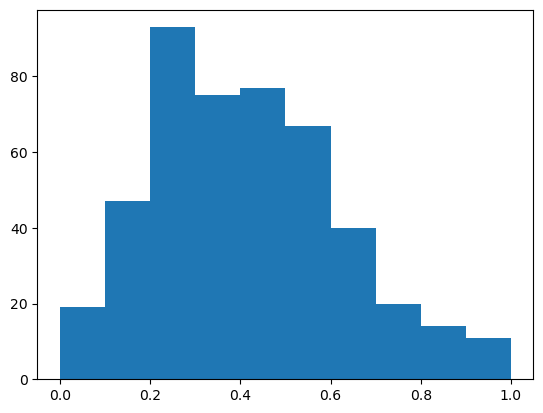

In [147]:
plt.hist(metadata_full["scaled_pct_change"])

In [148]:
df = metadata_full.merge(genecounts_scaled, on = "seq_sample_id")
df = df.round(2)
df

,seq_sample_id,age,BMI,scaled_pct_change,category,ENSG00000000003.16,ENSG00000000419.14,ENSG00000000457.14,ENSG00000000971.17,ENSG00000001036.14,...,ENSG00000308270.1,ENSG00000309097.1,ENSG00000309174.1,ENSG00000309618.1,ENSG00000310376.1,ENSG00000310517.1,ENSG00000310523.1,ENSG00000310526.1,ENSG00000310527.1,ENSG00000310533.1
0,s104,46.0,29.0,0.42,Average_responder,-1.22,0.09,-0.74,-0.21,-0.98,...,-0.61,-1.12,-1.09,-1.25,0.45,1.69,-0.17,-0.06,-0.03,-1.34
1,s112,53.0,30.3,0.33,Average_responder,-0.96,0.11,-0.70,0.09,-0.77,...,-0.40,-1.53,-1.08,-1.24,-0.05,1.82,-0.22,0.43,0.25,-1.12
2,s13,46.0,25.3,0.92,High_responder,-1.23,0.09,-0.72,-0.21,-0.86,...,-0.71,-1.55,-1.48,-1.43,0.94,1.43,0.14,0.50,0.49,-1.18
3,s130,58.0,29.9,0.26,Average_responder,-1.29,-0.00,-0.49,-0.08,-1.13,...,-1.27,-1.40,-0.69,-1.03,0.83,1.76,0.24,0.48,0.41,-1.21
4,s136,48.0,18.4,0.66,Average_responder,-1.06,0.13,-0.63,0.02,-0.79,...,-0.80,-1.38,-1.19,-0.96,0.65,1.79,-0.26,0.02,-0.03,-1.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,FP6w0R,21.8,20.5,0.09,No_responder,-0.58,0.55,-0.41,0.31,-0.78,...,-0.06,-1.17,-0.81,-0.52,2.96,1.74,-0.99,-0.68,-0.81,-0.84
459,FP7w0L,21.2,28.2,0.73,Average_responder,-0.93,0.61,-0.50,0.12,-0.93,...,0.43,-0.72,-1.38,-0.46,2.97,1.77,-1.16,-0.59,-0.90,-1.16
460,FP7w0R,21.2,28.2,0.94,High_responder,-0.84,0.60,-0.67,0.16,-0.95,...,0.29,-0.84,-1.13,-0.52,2.96,1.78,-0.76,-0.24,-0.71,-1.35
461,FP9w0R,20.6,21.2,0.65,Average_responder,-0.90,0.59,-0.47,-0.18,-0.81,...,0.57,-0.93,-1.64,-0.26,2.92,1.86,-0.53,-0.10,-0.40,-1.32


In [149]:
X = df.drop(["seq_sample_id", "scaled_pct_change", "category"], axis = 1)
y = df["scaled_pct_change"]
y = np.array(y)

In [150]:
#split into train and test. Test set will be 20% of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,random_state =123)

# from the training set, extract the validation set
X_train, X_val,  y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 123)

# print their shapes

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Testing set:", X_test.shape, y_test.shape)

Training set: (296, 10928) (296,)
Validation set: (74, 10928) (74,)
Testing set: (93, 10928) (93,)


In [151]:
#Start with the input layer, where we must indicate the shape of the Data passed to the model. 
inputs = tf.keras.layers.Input(shape=(10928,))
#Add dense layers to the input layer. These layers are commom to both predicted variables. 
x = Dense(units=64, activation='relu')(inputs)
x = Dense(units=64, activation='relu')(x)

#Add the output layer for the pct_rank using Sigmoid activation. 
y_rank_layer = Dense(units = 1, kernel_regularizer = regularizers.l1(0.001))(x)


#The Model is created indicating the input and output. 
model = Model(inputs=inputs, outputs=y_rank_layer)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss = tf.keras.losses.Huber(delta = 0.5),
             metrics= ["mean_squared_error", "mae"])

In [152]:
model.summary()

Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_44 (InputLayer)          │ (None, 10928)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_132 (Dense)                    │ (None, 64)                  │         699,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_133 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_134 (Dense)                    │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 703,681 (2.68 MB)

 Trainable params: 703,681 (2.68 MB)

 Non-trainable params: 0 (0.00 B)

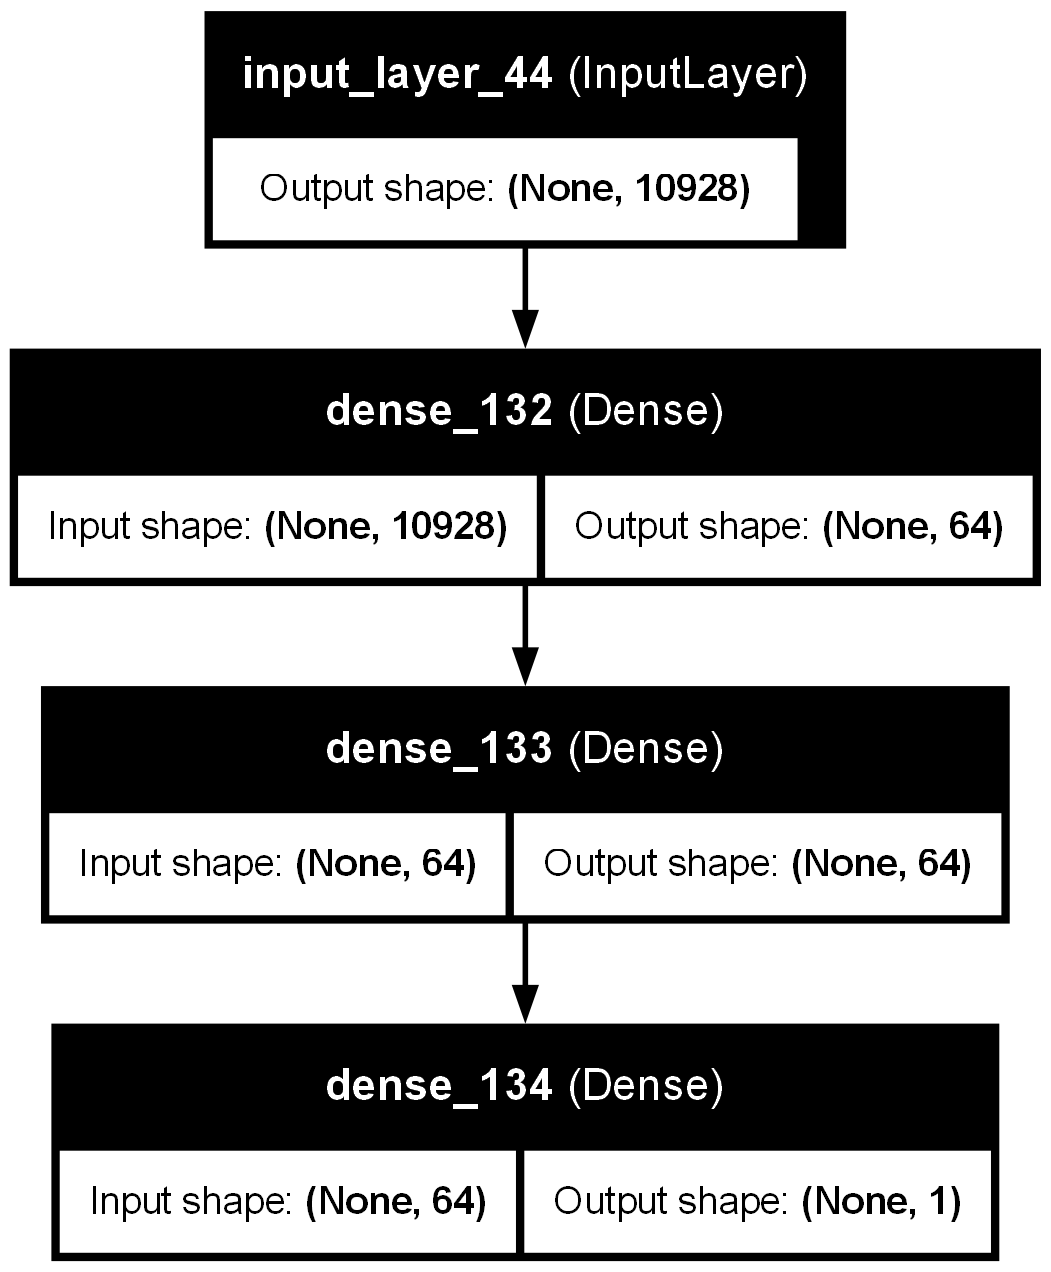

In [153]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [154]:
model.fit(X_train, 
         y_train,
          epochs = 32,
          batch_size=64,
         validation_data=(X_val, y_val))

Epoch 1/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 0.6113 - mae: 1.4464 - mean_squared_error: 2.5473 - val_loss: 0.2269 - val_mae: 0.6748 - val_mean_squared_error: 0.5205
Epoch 2/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1616 - mae: 0.5138 - mean_squared_error: 0.3498 - val_loss: 0.1124 - val_mae: 0.4153 - val_mean_squared_error: 0.2113
Epoch 3/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0920 - mae: 0.3403 - mean_squared_error: 0.1773 - val_loss: 0.0638 - val_mae: 0.2667 - val_mean_squared_error: 0.1104
Epoch 4/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0545 - mae: 0.2429 - mean_squared_error: 0.0890 - val_loss: 0.0560 - val_mae: 0.2616 - val_mean_squared_error: 0.0904
Epoch 5/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0439 - mae: 0.2078 - mean_squared_error: 0.0667 - val_loss: 0.0423 - val_mae: 0.1934 - val_mean_squared_error: 0.0638
Epoch 6/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0409 - mae: 0.1956 - mean_squared_error: 0.0607 - val_l

In [142]:

#Create a SHAP explainer
explainer = shap.KernelExplainer(model, X_train)

# Generate SHAP values
shap_values = explainer.shap_values(X_val)

# Visualize SHAP values
#shap.summary_plot(shap_values, X_val)
#shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_val.iloc[0])
#shap_values = explainer.shap_values(X_val.iloc[:,:])
shap.summary_plot(shap_values,X_val,plot_type="bar", max_display=18)
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_val.iloc[0])

  0%|          | 0/84 [00:00<?, ?it/s]

MemoryError: Unable to allocate 1.43 TiB for an array with shape (69490, 2832564) and data type float64